# ChemTab (PCDNN_V2) Benchmark Notebook
### This notebook contains experiments around the different parameters for the model
#### Amol Salunkhe

Develop a deep neural architecture ChemTab that jointly optimizes two neural networks for the tasks of reduced basis learning (encoder) and reverse lookup function learning (regressor). The first network (Shallow AutoEncoder) will focus on linear dimensionality reduction and create a linear embedding for the source species. The second network (Deep Regressor) will focus on learning a lookup function from the linear embedding to the Thermo-chemical state variables.

### Overall Problem Formulation

\begin{equation}\label{eqn:lossfunc}
    \begin{aligned}
    \textrm{min} \quad \mathcal{L}_{joint} = \lambda_{encoder} * \mathcal{L}_{encoder} + \lambda_{regressor}* \mathcal{L}_{regressor} 
    \end{aligned}
\end{equation}

### Reduced Basis Problem Formulation (Encoder)

\begin{equation}\label{eqn:Reduced-Basis-Learning}
    \begin{aligned}
    \def\sss{\scriptscriptstyle}
    {}
    \def\stacktype{L}
        {\mathrm{Y^{'}}}{\sss n\times k} =  {Y}{\sss n\times s} \times {W}{\sss s\times k} \\
        \textrm{s.t.,} \quad k \ll s\\
        \mathrm{\phi}(Y) \approx \mathrm{\phi}(Y^{'})\\
        \textrm{where, W is the Reduced Basis / encoder} \\
        \mathrm{\phi} \quad \textrm{is the Reverse Lookup function / regressor}
    \end{aligned}
\end{equation}


### Lookup Learning Problem Formulation (Regressor)

\begin{equation}\label{eqn:Reverse-Lookup-Learning}
    \begin{aligned}
        \textrm{min} \quad ||{S_i} - \mathrm{\phi}(Y^{'}_i)||_{p}\\
        \textrm{s.t.,} \quad p \in r \\
        \quad k \ll s\\
        \mathrm{\phi}(Y) \approx \mathrm{\phi}(Y^{'})\\
    \end{aligned}
\end{equation}




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
import time
from sklearn.decomposition import PCA, SparsePCA
%matplotlib inline
import seaborn as sns
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
import sys

# util for getting objects' fields' names
field_names = lambda x: [k for k in vars(x).keys() if not k.startswith('_')]

## Helpers

In [2]:
from benchmark_model_code import * # Network Helpers
from benchmark_data_code import * # Data Helpers
from tensorflow.keras import layers as L
halfData = getHalfData()

Yi_col: ['YiCH4', 'YiH', 'YiO', 'YiO2', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiH2', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5', 'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiN', 'YiNH', 'YiNH2', 'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiHNO', 'YiCN', 'YiHCN', 'YiH2CN', 'YiHCNN', 'YiHCNO', 'YiHOCN', 'YiHNCO', 'YiNCO', 'YiC3H7', 'YiC3H8', 'YiCH2CHO', 'YiCH3CHO', 'YiN2', 'YiAR']
53
source term cols: ['souspecCH4', 'souspecH', 'souspecO', 'souspecO2', 'souspecOH', 'souspecH2O', 'souspecHO2', 'souspecH2O2', 'souspecC', 'souspecCH', 'souspecCH2', 'souspecCH2(S)', 'souspecCH3', 'souspecH2', 'souspecCO', 'souspecCO2', 'souspecHCO', 'souspecCH2O', 'souspecCH2OH', 'souspecCH3O', 'souspecCH3OH', 'souspecC2H', 'souspecC2H2', 'souspecC2H3', 'souspecC2H4', 'souspecC2H5', 'souspecC2H6', 'souspecHCCO', 'souspecCH2CO', 'souspecHCCOH', 'souspecN', 'souspecNH', 'souspecNH2', 'souspecN

/home/dwyerdei/rom_project/src/benchmark_data_code.py:289: UserWarning: transparently scaling Zmix!
  warnings.warn('transparently scaling Zmix!')


In [3]:
#df = pd.read_csv('../NewData_flames_data_with_L1_L2_errors_CH4-AIR_without_trimming(SouSpec_Included).txt')
#df=df.drop(columns='YiAR') # drop this because it is inert and has no corresponding source term

In [3]:
Yi_cols = [col for col in df.columns if col[:2]=='Yi']
print(f'Yi_col: {Yi_cols}')
print(len(Yi_cols))
source_term_cols = ['souspec' + col[2:] for col in Yi_cols]
#source_term_cols2 = [col for col in df.columns if col.lower().startswith('souspec')]
print(f'source term cols: {source_term_cols}')
#print(f'source term cols2: {source_term_cols2}')

encoding_dim = 4
n_species = len(Yi_cols) # only 52

'''
X_allSpecies6 = df[Yi_cols].values
X_allSources = df[source_term_cols].values
Y_souener = df['souener']
speciesInputScaler = MinMaxScaler
sourcesInputScaler = MinMaxScaler
souenerOutputScaler = MinMaxScaler
'''

Yi_col: ['YiCH4', 'YiH', 'YiO', 'YiO2', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiH2', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5', 'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiN', 'YiNH', 'YiNH2', 'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiHNO', 'YiCN', 'YiHCN', 'YiH2CN', 'YiHCNN', 'YiHCNO', 'YiHOCN', 'YiHNCO', 'YiNCO', 'YiC3H7', 'YiC3H8', 'YiCH2CHO', 'YiCH3CHO', 'YiN2', 'YiAR']
53
source term cols: ['souspecCH4', 'souspecH', 'souspecO', 'souspecO2', 'souspecOH', 'souspecH2O', 'souspecHO2', 'souspecH2O2', 'souspecC', 'souspecCH', 'souspecCH2', 'souspecCH2(S)', 'souspecCH3', 'souspecH2', 'souspecCO', 'souspecCO2', 'souspecHCO', 'souspecCH2O', 'souspecCH2OH', 'souspecCH3O', 'souspecCH3OH', 'souspecC2H', 'souspecC2H2', 'souspecC2H3', 'souspecC2H4', 'souspecC2H5', 'souspecC2H6', 'souspecHCCO', 'souspecCH2CO', 'souspecHCCOH', 'souspecN', 'souspecNH', 'souspecNH2', 'souspecN

"\nX_allSpecies6 = df[Yi_cols].values\nX_allSources = df[source_term_cols].values\nY_souener = df['souener']\nspeciesInputScaler = MinMaxScaler\nsourcesInputScaler = MinMaxScaler\nsouenerOutputScaler = MinMaxScaler\n"

### Constrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding; All Constraints)

In [4]:

'''
species_inputs = keras.Input(shape=(n_species,), name="species_input")
Zmix = keras.Input(shape=(1,), name="Zmix")

W_emb_layer = layers.Dense(encoding_dim, activation="linear",kernel_constraint=UnitNorm(axis=0),
                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0),
                 activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.))

# use same layer to compute real source_terms as 
x = W_emb_layer(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

#Predict the source energy
souener_pred = layers.Dense(1, name="souener_prediction")(x)
base_regression_model = keras.Model(inputs=[species_inputs], outputs=[souener_pred])
'''

'\nspecies_inputs = keras.Input(shape=(n_species,), name="species_input")\nZmix = keras.Input(shape=(1,), name="Zmix")\n\nW_emb_layer = layers.Dense(encoding_dim, activation="linear",kernel_constraint=UnitNorm(axis=0),\n                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0),\n                 activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.))\n\n# use same layer to compute real source_terms as \nx = W_emb_layer(species_inputs)\n\n#Concatenate the Linear Embedding and Zmix together\nx = layers.Concatenate()([Zmix, x])\nx = layers.Dense(32, activation="relu")(x)\nx = layers.Dense(64, activation="relu")(x)\nx = layers.Dense(128, activation="relu")(x)\nx = layers.Dense(256, activation="relu")(x)\nx = layers.Dense(512, activation="relu")(x)\nx = layers.Dense(256, activation="relu")(x)\nx = layers.Dense(128, activation="relu")(x)\nx = layers.Dense(64, activation="relu")(x)\nx = layers.Dense(32, activation="relu")(x

In [5]:
"""
base_regression_model.output_names = ['dynamic_source_prediction', 'static_source_prediction']
base_regression_model.save('temp.h5')
base_regression_model = keras.models.load_model('temp.h5', custom_objects=factory.concreteClassCustomObject)
print(base_regression_model.output_names)
"""

"\nbase_regression_model.output_names = ['dynamic_source_prediction', 'static_source_prediction']\nbase_regression_model.save('temp.h5')\nbase_regression_model = keras.models.load_model('temp.h5', custom_objects=factory.concreteClassCustomObject)\nprint(base_regression_model.output_names)\n"

In [4]:
from models.pcdnnv2_model_factory import *

factory = PCDNNV2ModelFactory()

base_regression_model = keras.models.load_model('static_deps_model_template.h5', custom_objects=factory.concreteClassCustomObject)
#base_regression_model = keras.models.load_model('souener_only_model_template.h5', custom_objects=factory.concreteClassCustomObject)
base_regression_model._name = 'base_regression_model'

base_regression_model.output_names = ['dynamic_source_prediction', 'static_source_prediction']
print(base_regression_model.output_names)

Parent DNNModelFactory Instantiated
ListWrapper(['dynamic_source_prediction', 'static_source_prediction'])


2022-03-07 21:25:27.618565: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 21:25:28.000943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14201 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


regressor


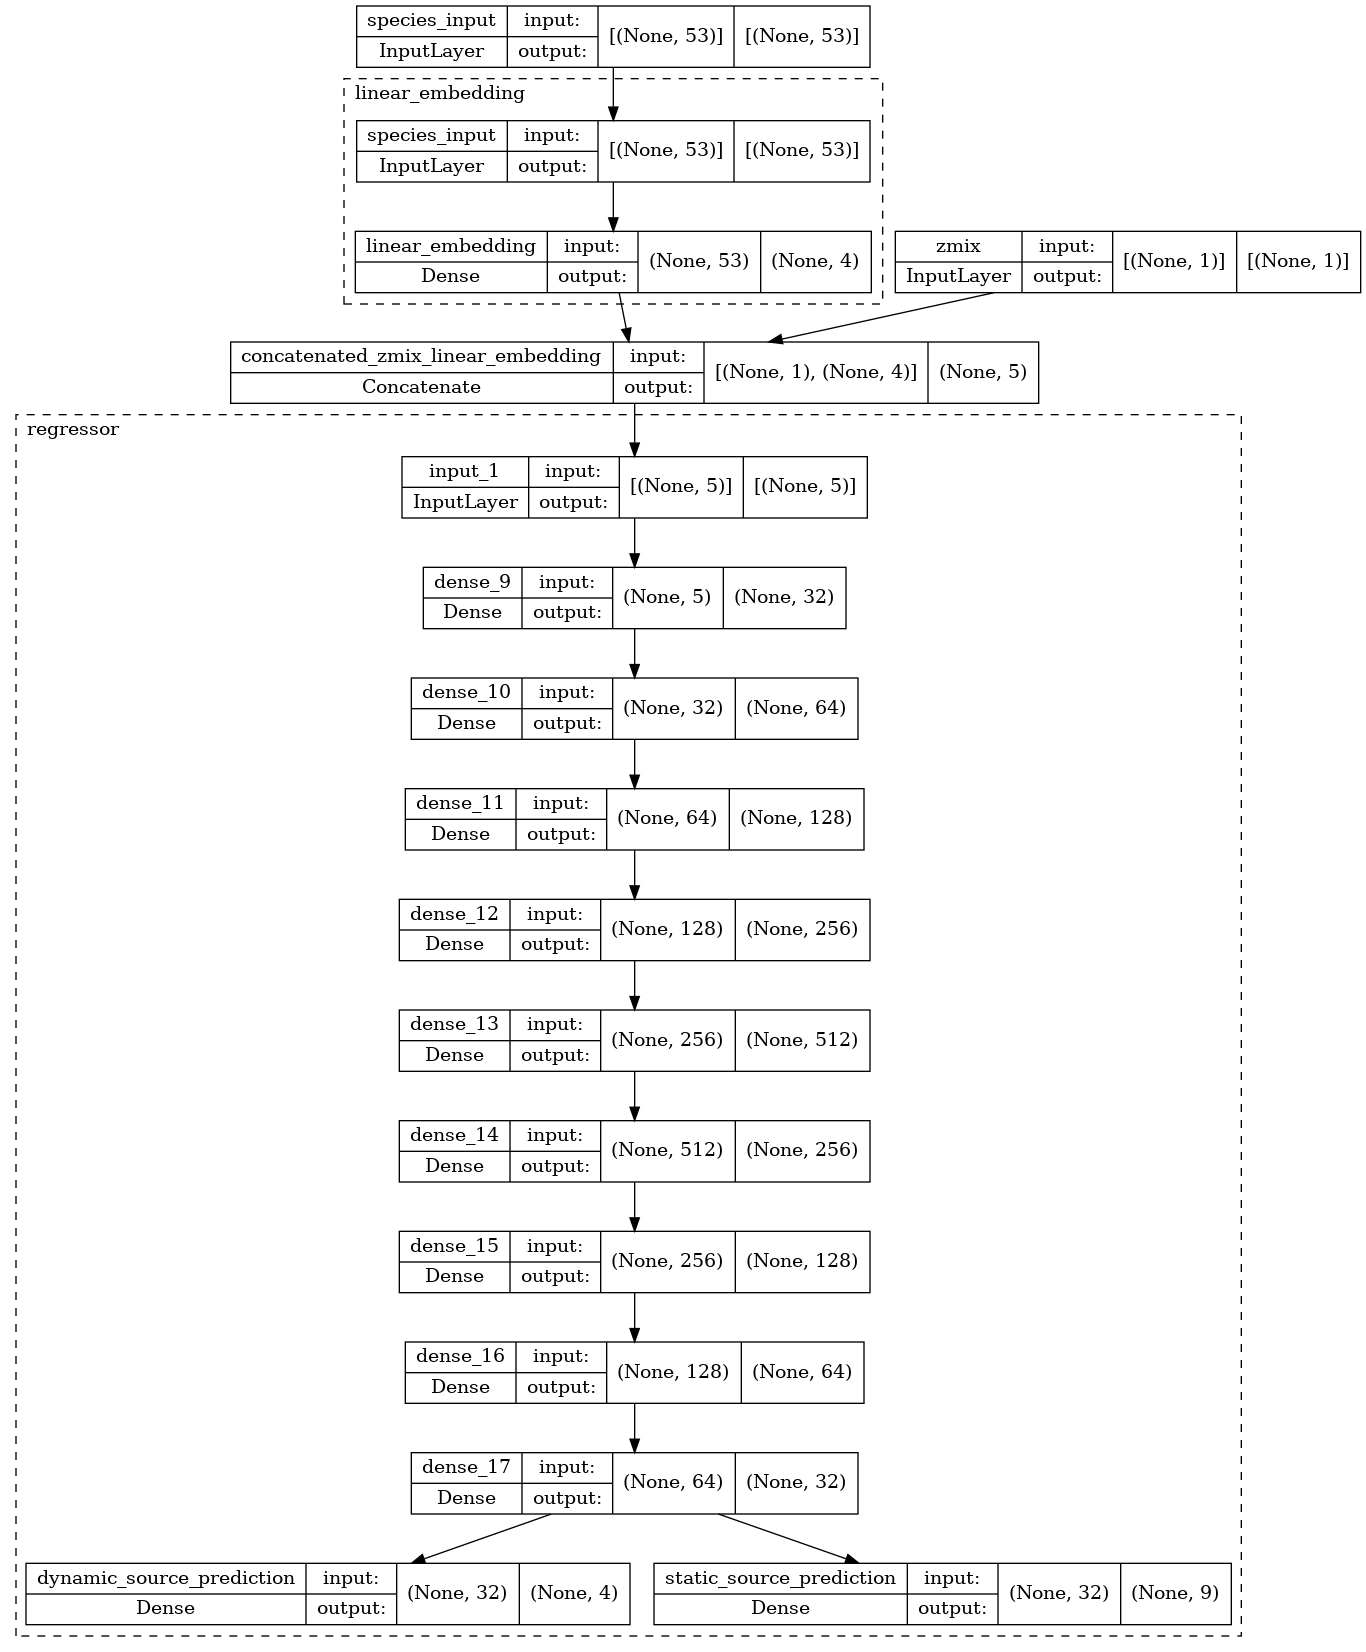

In [5]:
print(base_regression_model.layers[-1].name)
tf.keras.utils.plot_model(base_regression_model, expand_nested=True, show_shapes=True)

In [8]:
#species_inputs = keras.Input(shape=(n_species,), name="species_input")
#Zmix = keras.Input(shape=(1,), name="Zmix")
#x = base_regression_model((species_inputs, Zmix))
#print(x)

# base_regression_model.build(input_shape={"species_input": (53,), "Zmix": (1,), "source_term_input": (8,)})

In [9]:
# NOTE on indices: first '[0]' is to select first input, 2nd '[1]' is to skip past batch dimension
#print(np.squeeze(base_regression_model.get_layer('linear_embedding').output_shape)[1])
#base_regression_model.outputs=base_regression_model.outputs + []
#print(base_regression_model.outputs)
#print(base_regression_model.losses)

In [10]:
base_regression_model.output_shape

{'static_source_prediction': (None, 9), 'dynamic_source_prediction': (None, 4)}

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

# verified to work 1/31/21
def get_dynamic_source_truth_model(W_emb_layer):
    source_term_inputs = keras.Input(shape=(n_species,), name='source_term_input')
    source_term_truth = W_emb_layer(source_term_inputs)
    source_term_truth_model = keras.Model(inputs=source_term_inputs, outputs=source_term_truth, name='source_term_truth')
    return source_term_truth_model

def dynamic_source_term_pred_wrap(base_regression_model):
    # verified to work (when assert holds)
    # copies a models input dictionary, for reuse in a higher level model
    def copy_model_inputs(model):
        input_shape = model.input_shape
        if isinstance(model.input_shape, dict):
            # we assume coherence between input_shapes and input_names, if not true then it should be made so
            assert np.all(np.isin(model.input_names, list(model.input_shapes.keys())))
            input_shape = (model.input_shape[name] for name in model.input_names)
        return [layers.Input(shape[1:],name=name) for name,shape in zip(model.input_names,input_shape)]
    
    # NOTE on indices: first squeeze is to select first input, 2nd '[1]' is to skip past batch dimension
    n_species = np.squeeze(base_regression_model.get_layer('species_input').input_shape)[1]
    encoding_dim = np.squeeze(base_regression_model.get_layer('linear_embedding').output_shape)[1]
    
    # copy model inputs for container model & call base_regression_model as layer/module
    copied_inputs = copy_model_inputs(base_regression_model)
    regression_outputs = base_regression_model(copied_inputs)
    dynamic_source_pred = regression_outputs['dynamic_source_prediction']
    
    all_species_source_inputs = keras.Input(shape=(n_species,), name='source_term_input')
    W_emb_layer = base_regression_model.get_layer('linear_embedding')
    dynamic_source_truth_model = get_dynamic_source_truth_model(W_emb_layer)
    dynamic_source_truth = dynamic_source_truth_model(all_species_source_inputs)
    dynamic_source_all = layers.Concatenate(name='dynamic_source_prediction')([dynamic_source_pred, dynamic_source_truth])
    # give it the same name as the original layer name, so it is easier to drop-in place 
    
    # This + source_term_truth_model facilitates dynamic source term training!
    container_model = keras.Model(
        inputs=copied_inputs + [all_species_source_inputs],
        outputs={'static_source_prediction': regression_outputs['static_source_prediction'],
                 'dynamic_source_prediction': dynamic_source_all},
        name='container_model'
    )
    return container_model

In [7]:
output_layer_names = [l.name for l in base_regression_model._output_layers]
print(output_layer_names)
print(base_regression_model.output_names)
print(base_regression_model.input_names)
print(base_regression_model.input_shape)
print(base_regression_model.get_layer('regressor').output_names)

['regressor', 'regressor']
ListWrapper(['dynamic_source_prediction', 'static_source_prediction'])
['species_input', 'zmix']
[(None, 53), (None, 1)]
['dynamic_source_prediction', 'static_source_prediction']


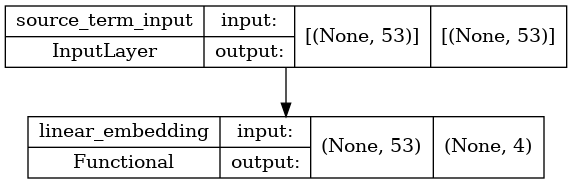

In [8]:
W_emb_layer = base_regression_model.get_layer('linear_embedding')
source_term_truth_model = get_dynamic_source_truth_model(W_emb_layer)
tf.keras.utils.plot_model(source_term_truth_model,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [11]:
container_model = dynamic_source_term_pred_wrap(base_regression_model)
container_model.build(input_shape={"species_input": (53,), "Zmix": (1,), "source_term_input": (53,)})
container_model.summary(expand_nested=False)

print(container_model.output_shape)
print(container_model.input_shape)
print(container_model.input_names)
print(container_model.output_names)
#extracted_model = container_model.get_layer('base_regressor_model')

Model: "container_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 species_input (InputLayer)     [(None, 53)]         0           []                               
                                                                                                  
 zmix (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 source_term_input (InputLayer)  [(None, 53)]        0           []                               
                                                                                                  
 base_regression_model (Functio  {'static_source_pre  350437     ['species_input[0][0]',          
 nal)                           diction': (None, 9)               'zmix[0][0]']     

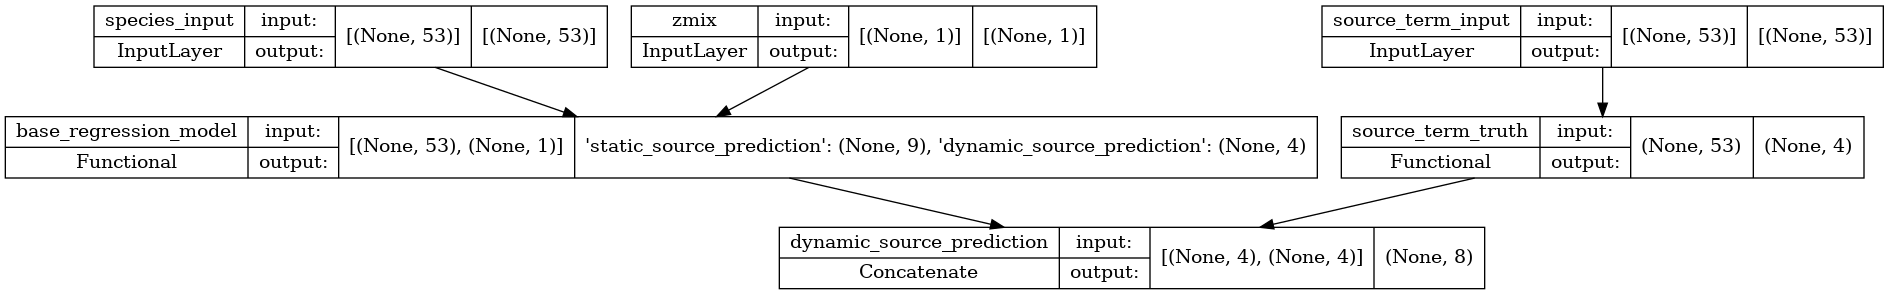

In [12]:
tf.keras.utils.plot_model(container_model,
    show_shapes=True,
    show_layer_names=True,
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
import sys

from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
from tensorflow.keras import backend as K

class WeightsOrthogonalityConstraint (Constraint):
    def __init__(self, encoding_dim, weightage = 1.0, axis = 0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
        self.axis = axis

    def weights_orthogonality(self, w):
        if(self.axis==1):
            w = tf.transpose(w)
        if(self.encoding_dim > 1):
            m = tf.matmul(tf.transpose(w), w) - tf.eye(self.encoding_dim)
            return self.weightage * tf.math.sqrt(tf.math.reduce_sum(tf.math.square(m)))
        else:
            m = tf.math.reduce_sum(w ** 2) - 1.
            return m

    def __call__(self, w):
        return self.weights_orthogonality(w)

                                                                                                                                                                                          22,1          Top

    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [13]:
################# Losses ################

def source_term_loss(y_true, y_pred):
    encoding_dim = y_true.shape[1]//2
    abs_diff = tf.math.abs(y_pred[:,:encoding_dim]-y_pred[:,encoding_dim:])
    return tf.reduce_mean(abs_diff, axis=-1)  # Note the `axis=-1`
losses={'static_source_prediction': 'mae', 'dynamic_source_prediction': source_term_loss}

################ Metrics ################

def R2(yt,yp): return tf.reduce_mean(1-tf.reduce_mean((yp-yt)**2, axis=0)/(tf.math.reduce_std(yt,axis=0)**2))
def R2_split(yt,yp):
    assert yt.shape[1]//2 == yp.shape[1]/2
    encoding_dim = yt.shape[1]//2
    yt=yp[:,:encoding_dim]
    yp=yp[:,encoding_dim:]
    # NOTES: verified that len(yt.shape)==2 and yt.shape[0] is None
    assert len(yt.shape)==2
    assert yt.shape[0] is None
    return 1-tf.math.reduce_mean((yp-yt)**2, axis=0)/(tf.math.reduce_std(yt,axis=0)**2)
metrics = {'static_source_prediction': R2, 'dynamic_source_prediction': R2_split}
#########################################

container_model.compile(loss=losses,optimizer=tf.keras.optimizers.Adam(0.001), metrics=metrics)

In [14]:
container_model.metrics

[]

In [15]:
n_static_source_terms = base_regression_model.get_layer('regressor').output_shape['static_source_prediction'][1]
print('n_static_source_terms:',n_static_source_terms)

normalized_species_train = halfData["normalized_species_train"]
normalized_sources_train = halfData['normalized_sources_train']

Zmix_train = halfData["Zmix_train"].reshape(-1,1)
normalized_souener_train = halfData["normalized_souener_train"].reshape(-1,1)
dummy_source_term_train = np.zeros(shape=(normalized_souener_train.shape[0],8))
print('dummy.shape:', dummy_source_term_train.shape)

key = None
for key in locals():
    if key.endswith('train'):
        print(f'{key}.type={type(locals()[key])}')
        print(f'{key}.shape={locals()[key].shape}')

print('input_shape:', container_model.input_shape)
print('output_shape:', container_model.output_shape)
static_source_train = normalized_sources_train[:,:n_static_source_terms]
history = container_model.fit({'species_input': normalized_species_train,'zmix': Zmix_train, 'source_term_input': normalized_sources_train}, 
                     {'static_source_prediction': static_source_train, 'dynamic_source_prediction': dummy_source_term_train},
                     validation_split=0.2,
                     verbose=1, 
                     epochs=100,
                     batch_size=64,
                     callbacks=[es])

n_static_source_terms: 9
dummy.shape: (8222, 8)
normalized_species_train.type=<class 'numpy.ndarray'>
normalized_species_train.shape=(8222, 53)
normalized_sources_train.type=<class 'numpy.ndarray'>
normalized_sources_train.shape=(8222, 53)
Zmix_train.type=<class 'numpy.ndarray'>
Zmix_train.shape=(8222, 1)
normalized_souener_train.type=<class 'numpy.ndarray'>
normalized_souener_train.shape=(8222, 1)
dummy_source_term_train.type=<class 'numpy.ndarray'>
dummy_source_term_train.shape=(8222, 8)
input_shape: [(None, 53), (None, 1), (None, 53)]
output_shape: {'static_source_prediction': (None, 9), 'dynamic_source_prediction': (None, 8)}
Epoch 1/100
103/103 [==============================] - 3s 16ms/step - loss: 0.1255 - dynamic_source_prediction_loss: 0.0556 - base_regression_model_loss: 0.0658 - dynamic_source_prediction_R2_split: -16397.5840 - base_regression_model_R2: -327.5324 - val_loss: 0.0937 - val_dynamic_source_prediction_loss: 0.0449 - val_base_regression_model_loss: 0.0470 - val_dy

103/103 [==============================] - 1s 13ms/step - loss: 0.0628 - dynamic_source_prediction_loss: 0.0179 - base_regression_model_loss: 0.0428 - dynamic_source_prediction_R2_split: -11.0624 - base_regression_model_R2: 0.0999 - val_loss: 0.0610 - val_dynamic_source_prediction_loss: 0.0169 - val_base_regression_model_loss: 0.0422 - val_dynamic_source_prediction_R2_split: -9.0669 - val_base_regression_model_R2: 0.1071
Epoch 19/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0621 - dynamic_source_prediction_loss: 0.0169 - base_regression_model_loss: 0.0427 - dynamic_source_prediction_R2_split: -9.4377 - base_regression_model_R2: 0.1103 - val_loss: 0.0611 - val_dynamic_source_prediction_loss: 0.0160 - val_base_regression_model_loss: 0.0421 - val_dynamic_source_prediction_R2_split: -8.9400 - val_base_regression_model_R2: 0.0872
Epoch 20/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0610 - dynamic_source_prediction_loss: 0.0160 - base_regres

Epoch 37/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0531 - dynamic_source_prediction_loss: 0.0094 - base_regression_model_loss: 0.0425 - dynamic_source_prediction_R2_split: -12.0036 - base_regression_model_R2: 0.1365 - val_loss: 0.0528 - val_dynamic_source_prediction_loss: 0.0092 - val_base_regression_model_loss: 0.0419 - val_dynamic_source_prediction_R2_split: -11.5118 - val_base_regression_model_R2: 0.1526
Epoch 38/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0535 - dynamic_source_prediction_loss: 0.0092 - base_regression_model_loss: 0.0425 - dynamic_source_prediction_R2_split: -13.6194 - base_regression_model_R2: 0.1527 - val_loss: 0.0535 - val_dynamic_source_prediction_loss: 0.0090 - val_base_regression_model_loss: 0.0420 - val_dynamic_source_prediction_R2_split: -13.7479 - val_base_regression_model_R2: 0.1335
Epoch 39/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0539 - dynamic_source_prediction_loss: 0.00

Epoch 56/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0501 - dynamic_source_prediction_loss: 0.0065 - base_regression_model_loss: 0.0424 - dynamic_source_prediction_R2_split: -49.4420 - base_regression_model_R2: 0.1670 - val_loss: 0.0513 - val_dynamic_source_prediction_loss: 0.0064 - val_base_regression_model_loss: 0.0419 - val_dynamic_source_prediction_R2_split: -45.5577 - val_base_regression_model_R2: 0.1844
Epoch 57/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0515 - dynamic_source_prediction_loss: 0.0064 - base_regression_model_loss: 0.0425 - dynamic_source_prediction_R2_split: -57.2663 - base_regression_model_R2: 0.1598 - val_loss: 0.0498 - val_dynamic_source_prediction_loss: 0.0063 - val_base_regression_model_loss: 0.0421 - val_dynamic_source_prediction_R2_split: -44.6860 - val_base_regression_model_R2: 0.1700
Epoch 58/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0505 - dynamic_source_prediction_loss: 0.00

Epoch 75/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0490 - dynamic_source_prediction_loss: 0.0053 - base_regression_model_loss: 0.0423 - dynamic_source_prediction_R2_split: -60.9430 - base_regression_model_R2: 0.1400 - val_loss: 0.0489 - val_dynamic_source_prediction_loss: 0.0055 - val_base_regression_model_loss: 0.0421 - val_dynamic_source_prediction_R2_split: -38.9295 - val_base_regression_model_R2: 0.1387
Epoch 76/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0490 - dynamic_source_prediction_loss: 0.0053 - base_regression_model_loss: 0.0424 - dynamic_source_prediction_R2_split: -54.8451 - base_regression_model_R2: 0.1493 - val_loss: 0.0482 - val_dynamic_source_prediction_loss: 0.0053 - val_base_regression_model_loss: 0.0418 - val_dynamic_source_prediction_R2_split: -52.1495 - val_base_regression_model_R2: 0.1555
Epoch 77/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0487 - dynamic_source_prediction_loss: 0.00

Epoch 94/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0482 - dynamic_source_prediction_loss: 0.0046 - base_regression_model_loss: 0.0423 - dynamic_source_prediction_R2_split: -82.2044 - base_regression_model_R2: 0.1092 - val_loss: 0.0481 - val_dynamic_source_prediction_loss: 0.0047 - val_base_regression_model_loss: 0.0419 - val_dynamic_source_prediction_R2_split: -65.4254 - val_base_regression_model_R2: 0.1366
Epoch 95/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0481 - dynamic_source_prediction_loss: 0.0046 - base_regression_model_loss: 0.0423 - dynamic_source_prediction_R2_split: -78.9996 - base_regression_model_R2: 0.0884 - val_loss: 0.0477 - val_dynamic_source_prediction_loss: 0.0047 - val_base_regression_model_loss: 0.0419 - val_dynamic_source_prediction_R2_split: -82.9964 - val_base_regression_model_R2: 0.1794
Epoch 96/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0480 - dynamic_source_prediction_loss: 0.00

In [15]:
pd.DataFrame(normalized_sources_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
count,8.222000e+03,8222.000000,8222.000000,8222.000000,8222.000000,8222.000000,8.222000e+03,8.222000e+03,8222.000000,8222.000000,...,8.222000e+03,8.222000e+03,8.222000e+03,8.222000e+03,8.222000e+03,8.222000e+03,8222.000000,8222.000000,8.222000e+03,8222.0
mean,-4.858122e+02,1014.533079,1473.655908,-1472.133434,699.091003,2191.235697,3.277126e+04,3.326678e+03,30.636076,416.305489,...,-2.471317e+00,6.058593e-02,-1.130489e+00,3.771312e+00,8.603436e+01,8.994009e+02,1507.881346,494.636106,2.820243e-01,0.0
std,1.320991e+03,13387.183173,20916.258439,3815.331344,15939.507802,5018.365928,5.418994e+05,1.938368e+05,35618.211987,47522.672514,...,1.407290e+02,2.037776e+02,9.167234e+01,2.887968e+02,2.961436e+04,9.093079e+03,23404.597308,9448.560052,2.165889e+01,0.0
min,-8.929787e+03,-92294.316303,-83468.273468,-25864.967654,-54423.666609,-87.744356,-1.702105e+05,-8.212804e+05,-146327.031386,-177435.964502,...,-4.369682e+03,-4.148288e+03,-2.522357e+03,-4.726959e+03,-1.432108e+05,-4.655486e+04,-116748.697952,-68502.411428,-5.587709e+00,0.0
25%,-1.932633e+02,-1674.583710,-181.436731,-789.264281,-1010.616193,0.074753,-4.801015e+02,-5.423148e+02,-582.052632,-716.919723,...,-3.905837e-16,-7.241846e-15,-5.244189e-16,-5.687549e-14,-2.500394e+02,-6.970084e+00,-89.150168,-30.499449,-2.618158e-25,0.0
50%,-2.048115e+00,-91.301803,-0.030619,-24.280081,-1.649364,125.057222,-3.664143e+00,-1.475875e-01,-0.205807,-0.395632,...,-4.358516e-19,-2.645578e-17,9.070922e-20,-3.986621e-16,-7.545034e-01,-1.119427e-09,-0.315983,-0.011619,-4.861046e-30,0.0
75%,-7.684660e-13,-0.096121,0.017426,-0.041767,0.002136,1453.770136,1.364511e-03,3.442273e+00,-0.000031,-0.000011,...,2.156173e-17,-1.034672e-19,2.812840e-15,-4.660359e-19,-9.260626e-15,9.005756e+01,4.224796,0.175383,2.364123e-25,0.0
max,5.797417e+01,78298.333169,137567.639992,5084.417347,99903.683330,33372.221734,1.600816e+07,2.765927e+06,261443.706750,335085.724521,...,4.130057e+03,6.447198e+03,2.252415e+03,9.686399e+03,2.782657e+05,5.270567e+04,243275.998633,97748.869770,1.932457e+03,0.0


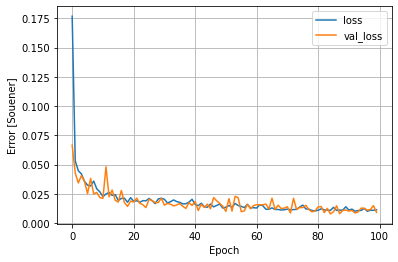

In [110]:
plot_loss(history)

In [112]:
normalized_species_test = halfData["normalized_species_test"]
normalized_sources_test = halfData['normalized_sources_test']

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict({'species_input': normalized_species_test,'Zmix': Zmix_test, 'source_term_input': normalized_sources_test})[0]

normalized_souener_pred = predictions

ValueError: in user code:

    File "/home/dwyerdei/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/home/dwyerdei/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dwyerdei/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/home/dwyerdei/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/home/dwyerdei/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/dwyerdei/.local/lib/python3.8/site-packages/keras/engine/input_spec.py", line 182, in assert_input_compatibility
        raise ValueError(f'Missing data for input "{name}". '

    ValueError: Missing data for input "blah". You passed a data dictionary with keys ['species_input', 'Zmix', 'source_term_input']. Expected the following keys: ['blah']


In [30]:
scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)
Y_pred = Y_pred.flatten()
Y_test = halfData["Y_test"]

In [33]:
err = computeAndPrintError(Y_pred, Y_test)

def print_scientific_notation(number):
    power = int(np.log(number)/np.log(10))
    print(f"Scientific Notation: {(number/10**power)}*10^{power}")
print_scientific_notation(615230621.10611)

Total Absolute Error:  5058426166734.437
Mean Absolute Error:  615230621.10611
Mean Percentage Error:  62.08635555097395
Total Squared Error:  3.6513484543220305e+22
Mean Squared Error:  4.4409492268572493e+18
Number of Points:  8222
Scientific Notation: 6.1523062110610995*10^8


In [43]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

NameError: name 'Y_test' is not defined

In [126]:
from tensorflow import keras
from tensorflow.keras import layers as L

i1 = L.Input(shape=(10,), name='blah')
o1 = L.Dense(16, name='o1')(i1)
o2 = L.Dense(16, name='o2')(i1)
model = keras.models.Model(inputs={'blah': i1}, outputs={'o1': o1, 'o2': o2})

named_outputs = {o.name.split('/')[0]:o for o in model.outputs}
named_inputs = {i.name.split('/')[0]:i for i in model.inputs}
print(named_inputs.keys())
print(named_inputs)

dict_keys(['blah'])
{'blah': <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'blah')>}


In [129]:
model.compile(loss='mse', optimizer='adam')
x = np.zeros(shape=(10,10))
y = np.zeros(shape=(10,16))
model.fit({'blah': x, 'nah': x},{'o1': y, 'o2': y})

1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00 - o1_loss: 0.0000e+00 - o2_loss: 0.0000e+00


In [55]:
def copy_model_inputs(model):
    input_shape = model.input_shape
    if isinstance(model.input_shape, dict):
        input_shape = (model.input_shape[name] for name in model.input_names)
    return [L.Input(shape[1:],name=name) for name,shape in zip(model.input_names,input_shape)]

print(model.input_shape)
print(model.input_names)
print(copy_model_inputs(model))

{'blah': (None, 10)}
['blah']
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'blah')>]


In [114]:
# copies a models input dictionary, for reuse in a higher level model
def copy_model_inputs(model):
    input_shape = model.input_shape
    if isinstance(model.input_shape, dict):
        input_shape = (model.input_shape[name] for name in model.input_names)
    return [L.Input(shape[1:],name=name) for name,shape in zip(model.input_names,input_shape)]
inputs = copy_model_inputs(base_regression_model)
print(inputs)

[<KerasTensor: shape=(None, 53) dtype=float32 (created by layer 'species_input')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'zmix')>]


In [44]:
get_model_input_dict = lambda model: {k:L.Input(v[1:], name=k) for k,v in zip(model.input_names, model.input_shape)}
inputs = get_model_input_dict(base_regression_model)
print(inputs)
outputs = base_regression_model(inputs)

copy_model = keras.models.Model(inputs=inputs, outputs=outputs)
print(copy_model.input_shape)
print(copy_model.output_shape)


tf.keras.utils.plot_model(copy_model,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96)

AttributeError: 'numpy.ndarray' object has no attribute 'Input'

In [116]:
field_names(base_regression_model)

['built',
 'inputs',
 'outputs',
 'input_names',
 'output_names',
 'stop_training',
 'history',
 'train_function',
 'test_function',
 'predict_function',
 'train_tf_function',
 'optimizer',
 'compiled_loss',
 'compiled_metrics',
 'loss']

## RESULTS SUMMARY

<table>
<tr>
<td>Method </td>
<td>MAE</td>
</tr>
<tr>
<td>Framework </td>
<td>2.24 E+09</td>
</tr>
<tr>
<td>DNN (Non-Linear Embedding) </td>
<td>9.304 E+08</td>
</tr>    
<tr>
<td>DNN (Linear Embedding [No Constraints]) </td>
<td>2.042 E+09</td>
</tr>       
<tr>
<td>ChemTab (Unit Norm Constraints) </td>
<td>6.28 E+08</td>
</tr>
<tr>
<td>ChemTab (Orthogonal Weights Constraints) </td>
<td>6.05 E+08</td>
</tr>
<tr>
<td>ChemTab (Uncorrelated Features Constraints) </td>
<td>5.7 E+08</td>
</tr>
<tr>
<td>ChemTab (All Constraints) </td>
<td>8.008 E+08</td>
</tr>
    
</table>